<a href="https://colab.research.google.com/github/ashraf1600/100-days-of-ML-by-CampusX/blob/main/paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install shap xgboost imbalanced-learn torch torchvision scikit-learn


In [28]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import shap
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    AdaBoostClassifier, GradientBoostingClassifier,
    BaggingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier


## LOAD DataSet and Clean Dataset


In [30]:
df = pd.read_csv("RT_IOT2022.csv")
print(df.shape)
df.head()


(123117, 85)


,Unnamed: 0,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
0,0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,...,0.0,2.972918e+07,2.972918e+07,2.972918e+07,2.972918e+07,0.0,64240,26847,502,MQTT_Publish
1,1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,...,0.0,2.985528e+07,2.985528e+07,2.985528e+07,2.985528e+07,0.0,64240,26847,502,MQTT_Publish
2,2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,...,0.0,2.984215e+07,2.984215e+07,2.984215e+07,2.984215e+07,0.0,64240,26847,502,MQTT_Publish
3,3,60893,1883,tcp,mqtt,31.961063,9,5,3,3,...,0.0,2.991377e+07,2.991377e+07,2.991377e+07,2.991377e+07,0.0,64240,26847,502,MQTT_Publish
4,4,51087,1883,tcp,mqtt,31.902362,9,5,3,3,...,0.0,2.981470e+07,2.981470e+07,2.981470e+07,2.981470e+07,0.0,64240,26847,502,MQTT_Publish


## Data Cleaning (RT-IoT2022 Specific)

In [31]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Remove zero-variance features
df = df.loc[:, df.nunique() > 1]


## Preprocessing

In [32]:
y = df["Attack_type"]
X = df.drop("Attack_type", axis=1)

cat_cols = ["proto", "service"]
num_cols = X.columns.difference(cat_cols)

preprocessor = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)

X = preprocessor.fit_transform(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


## CIBS – Class-Interleaving Balanced Sampling (Multiclass)

In [34]:
def CIBS(X, y):
    X = X.toarray() if hasattr(X, "toarray") else X
    df_tmp = pd.DataFrame(X)
    df_tmp["y"] = y

    groups = [g for _, g in df_tmp.groupby("y")]
    max_len = max(len(g) for g in groups)

    rows = []
    for i in range(max_len):
        for g in groups:
            if i < len(g):
                rows.append(g.iloc[i])

    df_new = pd.DataFrame(rows)
    y_new = df_new.pop("y")
    return df_new.values, y_new.values

X_bal, y_bal = CIBS(X, y)


## Feature Selection (14 Features)

In [35]:
et = ExtraTreesClassifier(n_estimators=300)
et.fit(X_bal, y_bal)

idx = np.argsort(et.feature_importances_)[-14:]
X_sel = X_bal[:, idx]


## Train-Test Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y_bal, test_size=0.3, stratify=y_bal, random_state=42
)


## Deep Learning Models (PyTorch)

#### CNN

In [37]:
class CNN(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.conv = nn.Conv1d(1, 32, 3)
        self.fc = nn.Linear(32*(n_features-2), n_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = torch.relu(self.conv(x))
        x = x.view(x.size(0), -1)
        return self.fc(x)


#####  LSTM

In [38]:
class LSTMModel(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.lstm = nn.LSTM(n_features, 64, batch_first=True)
        self.fc = nn.Linear(64, n_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])


#### Autoencoder (Anomaly + Multiclass Head)

In [39]:
class Autoencoder(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, n_features)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


#### Transformer Encoder (Tabular-Adapted)

In [40]:
class TransformerModel(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=n_features, nhead=2, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, 2)
        self.fc = nn.Linear(n_features, n_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.transformer(x)
        return self.fc(x[:, 0])


### Explainable AI (SHAP – Correct Usage)

##### Tree Models

/tmp/ipython-input-2783613211.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWa

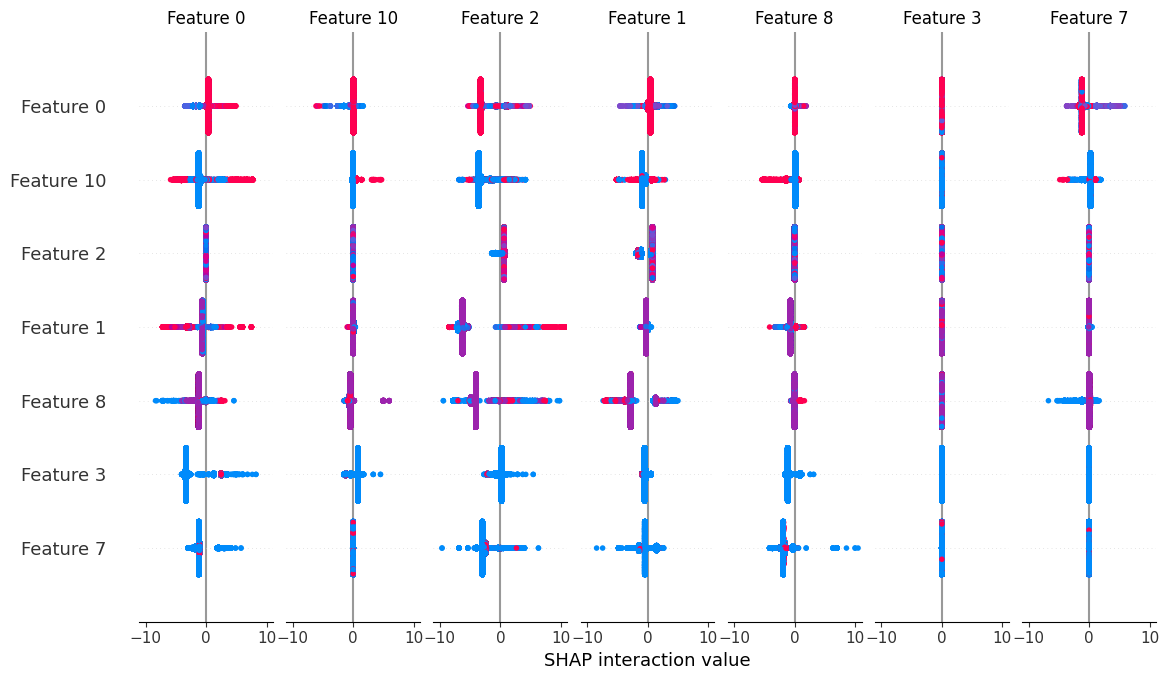

In [41]:
xgb = XGBClassifier(objective="multi:softprob", eval_metric="mlogloss")
xgb.fit(X_train, y_train)

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


##### Deep Learning (No DeepExplainer Bug)

/tmp/ipython-input-206025254.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_test[:50])
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: Futur

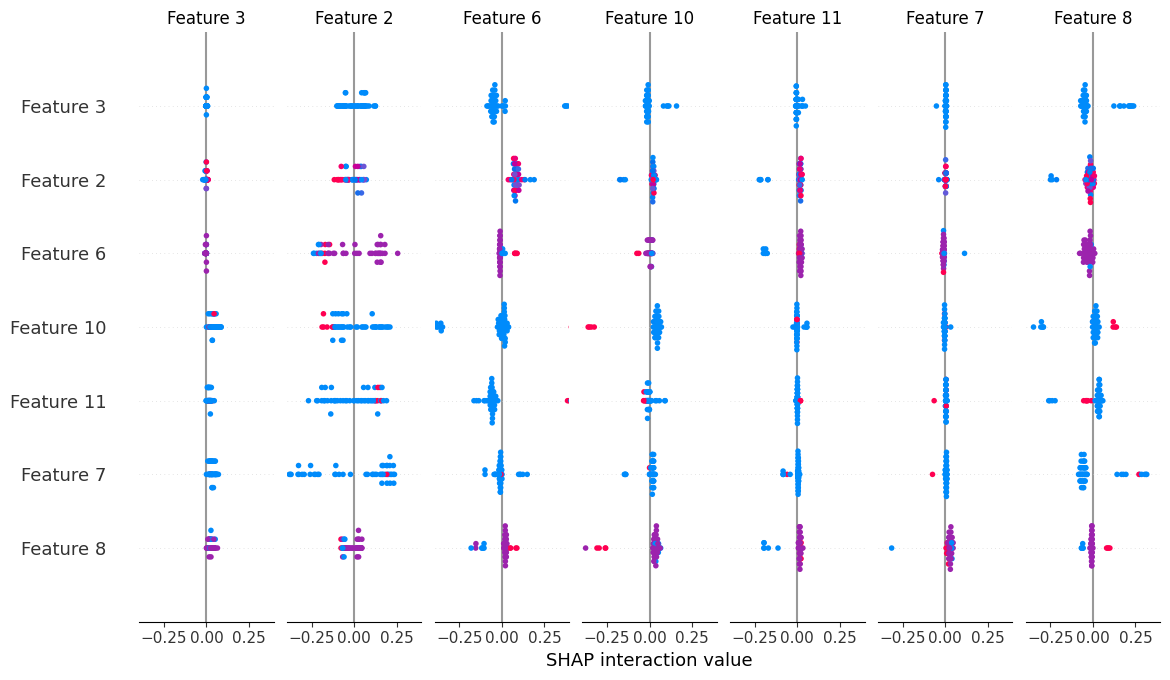

In [42]:
cnn = CNN(X_train.shape[1], len(np.unique(y)))
cnn.eval()

background = torch.tensor(X_train[:100], dtype=torch.float32)
test_t = torch.tensor(X_test[:50], dtype=torch.float32)

explainer = shap.GradientExplainer(cnn, background)
shap_vals = explainer.shap_values(test_t)

shap.summary_plot(shap_vals, X_test[:50])


### Common Evaluation Function (সব মডেলের জন্য)

In [43]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted"
    )

    return acc, prec, rec, f1


### ML / Ensemble Models Accuracy

In [44]:
acc, prec, rec, f1 = evaluate_model(xgb, X_test, y_test)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")


Accuracy : 0.9961
Precision: 0.9961
Recall   : 0.9961
F1-score : 0.9961


#### Deep Learning Models Accuracy (PyTorch)

In [45]:
def evaluate_dl(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X_test, dtype=torch.float32)
        y_t = torch.tensor(y_test, dtype=torch.long)

        outputs = model(X_t)
        preds = torch.argmax(outputs, dim=1)

    acc = accuracy_score(y_test, preds.numpy())
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, preds.numpy(), average="weighted"
    )

    return acc, prec, rec, f1


In [46]:
acc, prec, rec, f1 = evaluate_dl(cnn, X_test, y_test)

print("CNN Results")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")


CNN Results
Accuracy : 0.0339
Precision: 0.0123
Recall   : 0.0339
F1-score : 0.0180


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



### Automatic Results Table (Table-II Style)




In [47]:
results = []

models = {
    "Decision Tree": DecisionTreeClassifier().fit(X_train, y_train),
    "KNN": KNeighborsClassifier().fit(X_train, y_train),
    "Naive Bayes": GaussianNB().fit(X_train, y_train),
    "Random Forest": RandomForestClassifier().fit(X_train, y_train),
    "AdaBoost": AdaBoostClassifier().fit(X_train, y_train),
    "XGBoost": xgb
}

for name, model in models.items():
    acc, prec, rec, f1 = evaluate_model(model, X_test, y_test)
    results.append([name, acc, prec, rec, f1])

results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"]
)

results_df


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Accuracy,Precision,Recall,F1-score
0,Decision Tree,0.995804,0.995875,0.995804,0.995830
1,KNN,0.995127,0.995208,0.995127,0.995153
2,Naive Bayes,0.946150,0.952325,0.946150,0.944635
3,Random Forest,0.996426,0.996426,0.996426,0.996423
4,AdaBoost,0.880306,0.880384,0.880306,0.859181
5,XGBoost,0.996074,0.996106,0.996074,0.996084


In [50]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_dl(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X_test, dtype=torch.float32)
        y_t = torch.tensor(y_test, dtype=torch.long)

        outputs = model(X_t)
        preds = torch.argmax(outputs, dim=1)

    acc = accuracy_score(y_test, preds.cpu().numpy())
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, preds.cpu().numpy(), average="weighted"
    )

    return acc, prec, rec, f1


In [52]:
cnn = CNN(X_train.shape[1], len(np.unique(y_train)))
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

X_t = torch.tensor(X_train, dtype=torch.float32)
y_t = torch.tensor(y_train, dtype=torch.long)

for epoch in range(10):
    optimizer.zero_grad()
    outputs = cnn(X_t)
    loss = criterion(outputs, y_t)
    loss.backward()
    optimizer.step()


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_t = torch.tensor(y_train, dtype=torch.long).to(device)


In [55]:
lstm = LSTMModel(
    n_features=X_train.shape[1],
    n_classes=len(np.unique(y_train))
).to(device)

optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

lstm.train()
for epoch in range(10):
    optimizer.zero_grad()
    outputs = lstm(X_t)
    loss = criterion(outputs, y_t)
    loss.backward()
    optimizer.step()

    print(f"LSTM Epoch [{epoch+1}/10] - Loss: {loss.item():.4f}")


LSTM Epoch [1/10] - Loss: 2.5461
LSTM Epoch [2/10] - Loss: 2.5365
LSTM Epoch [3/10] - Loss: 2.5268
LSTM Epoch [4/10] - Loss: 2.5170
LSTM Epoch [5/10] - Loss: 2.5072
LSTM Epoch [6/10] - Loss: 2.4973
LSTM Epoch [7/10] - Loss: 2.4874
LSTM Epoch [8/10] - Loss: 2.4773
LSTM Epoch [9/10] - Loss: 2.4671
LSTM Epoch [10/10] - Loss: 2.4567


In [56]:
class AEClassifier(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.classifier = nn.Linear(32, n_classes)

    def forward(self, x):
        z = self.encoder(x)
        return self.classifier(z)


In [57]:
ae = AEClassifier(
    n_features=X_train.shape[1],
    n_classes=len(np.unique(y_train))
).to(device)

optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

ae.train()
for epoch in range(10):
    optimizer.zero_grad()
    outputs = ae(X_t)
    loss = criterion(outputs, y_t)
    loss.backward()
    optimizer.step()

    print(f"AE Epoch [{epoch+1}/10] - Loss: {loss.item():.4f}")


AE Epoch [1/10] - Loss: 2.3432
AE Epoch [2/10] - Loss: 2.3120
AE Epoch [3/10] - Loss: 2.2808
AE Epoch [4/10] - Loss: 2.2495
AE Epoch [5/10] - Loss: 2.2180
AE Epoch [6/10] - Loss: 2.1864
AE Epoch [7/10] - Loss: 2.1545
AE Epoch [8/10] - Loss: 2.1223
AE Epoch [9/10] - Loss: 2.0898
AE Epoch [10/10] - Loss: 2.0569


In [58]:
class TabTransformer(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.embed = nn.Linear(n_features, 64)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=64,
            nhead=4,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.fc = nn.Linear(64, n_classes)

    def forward(self, x):
        x = self.embed(x).unsqueeze(1)
        x = self.transformer(x)
        return self.fc(x[:, 0])


In [60]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 256  # safe value

train_dataset = TensorDataset(X_t, y_t)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)


In [61]:
transformer = TabTransformer(
    n_features=X_train.shape[1],
    n_classes=len(np.unique(y_train))
).to(device)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

transformer.train()
for epoch in range(12):
    epoch_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = transformer(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(
        f"Transformer Epoch [{epoch+1}/12] "
        f"- Loss: {epoch_loss/len(train_loader):.4f}"
    )


Transformer Epoch [1/12] - Loss: 0.1402
Transformer Epoch [2/12] - Loss: 0.0615
Transformer Epoch [3/12] - Loss: 0.0508
Transformer Epoch [4/12] - Loss: 0.0480
Transformer Epoch [5/12] - Loss: 0.0451
Transformer Epoch [6/12] - Loss: 0.0424
Transformer Epoch [7/12] - Loss: 0.0421
Transformer Epoch [8/12] - Loss: 0.0400
Transformer Epoch [9/12] - Loss: 0.0385
Transformer Epoch [10/12] - Loss: 0.0394
Transformer Epoch [11/12] - Loss: 0.0374
Transformer Epoch [12/12] - Loss: 0.0358


In [65]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, TensorDataset

def evaluate_dl_model(model, X_test, y_test, batch_size=256):
    model.to(device)
    model.eval()

    preds_all = []
    y_all = []

    test_dataset = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.long)
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            outputs = model(xb)
            preds = torch.argmax(outputs, dim=1)

            preds_all.extend(preds.cpu().numpy())
            y_all.extend(yb.cpu().numpy())

    acc = accuracy_score(y_all, preds_all)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_all, preds_all, average="weighted"
    )

    return acc, prec, rec, f1


In [66]:
dl_results = []

dl_models = {
    "CNN": cnn,
    "LSTM": lstm,
    "Autoencoder": ae,
    "Transformer": transformer
}

for name, model in dl_models.items():
    acc, prec, rec, f1 = evaluate_dl_model(model, X_test, y_test)
    dl_results.append([name, acc, prec, rec, f1])

dl_results_df = pd.DataFrame(
    dl_results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"]
)

dl_results_df


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

,Model,Accuracy,Precision,Recall,F1-score
0,CNN,0.798219,0.716529,0.798219,0.727810
1,LSTM,0.003682,0.061170,0.003682,0.005343
2,Autoencoder,0.802469,0.661883,0.802469,0.722379
3,Transformer,0.988575,0.988085,0.988575,0.988037


In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion(model, X_test, y_test, class_names):
    model.eval()
    preds = []

    with torch.no_grad():
        outputs = model(torch.tensor(X_test, dtype=torch.float32).to(device))
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

    plt.figure(figsize=(10,10))
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Per-Attack Confusion Matrix")
    plt.show()


In [70]:
epochs = 20
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [71]:
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")


Epoch [1/20] - Loss: 0.0349
Epoch [2/20] - Loss: 0.0333
Epoch [3/20] - Loss: 0.0335
Epoch [4/20] - Loss: 0.0323
Epoch [5/20] - Loss: 0.0316
Epoch [6/20] - Loss: 0.0303
Epoch [7/20] - Loss: 0.0317
Epoch [8/20] - Loss: 0.0282
Epoch [9/20] - Loss: 0.0305
Epoch [10/20] - Loss: 0.0290
Epoch [11/20] - Loss: 0.0285
Epoch [12/20] - Loss: 0.0291
Epoch [13/20] - Loss: 0.0290
Epoch [14/20] - Loss: 0.0284
Epoch [15/20] - Loss: 0.0287
Epoch [16/20] - Loss: 0.0273
Epoch [17/20] - Loss: 0.0272
Epoch [18/20] - Loss: 0.0273
Epoch [19/20] - Loss: 0.0284
Epoch [20/20] - Loss: 0.0267


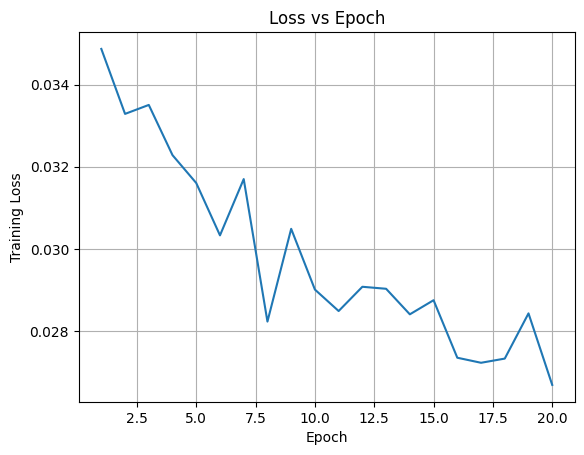

In [72]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, epochs+1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss vs Epoch")
plt.grid(True)
plt.show()


In [73]:
import shap

background = torch.tensor(X_train[:200], dtype=torch.float32).to(device)
test_samples = torch.tensor(X_test[:100], dtype=torch.float32).to(device)

explainer = shap.GradientExplainer(transformer, background)
shap_values = explainer.shap_values(test_samples)


In [75]:
class_names = sorted(np.unique(y_test))


/tmp/ipython-input-1352172813.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy glo

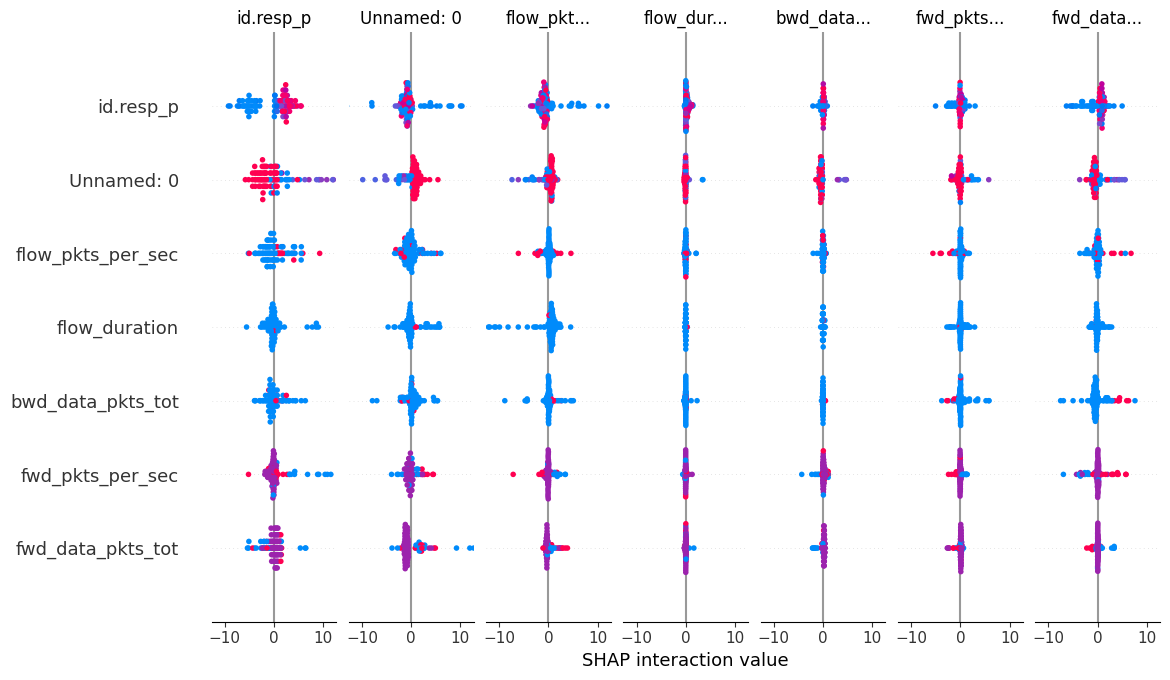

In [76]:
shap.summary_plot(
    shap_values,
    X_test[:100],
    feature_names=feature_names,
    class_names=class_names
)


In [77]:
TransformerConfig = {
    "embed_dim": 128,      # embedding dimension
    "num_heads": 8,        # multi-head attention
    "num_layers": 4,       # stacked encoder blocks
    "dropout": 0.2,        # regularization
    "lr": 0.0003,          # learning rate
    "batch_size": 256,     # mini-batch size
    "epochs": 20
}


In [78]:
import torch
import torch.nn as nn

class TabTransformer(nn.Module):
    def __init__(self, n_features, n_classes,
                 embed_dim=128, num_heads=8,
                 num_layers=4, dropout=0.2):
        super().__init__()

        self.embedding = nn.Linear(n_features, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, n_classes)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)           # (B, 1, E)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.classifier(x)


In [79]:
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# tensors
X_tr = torch.tensor(X_train, dtype=torch.float32)
y_tr = torch.tensor(y_train, dtype=torch.long)

train_ds = TensorDataset(X_tr, y_tr)
train_loader = DataLoader(
    train_ds,
    batch_size=TransformerConfig["batch_size"],
    shuffle=True
)

transformer = TabTransformer(
    n_features=X_train.shape[1],
    n_classes=len(np.unique(y_train)),
    embed_dim=TransformerConfig["embed_dim"],
    num_heads=TransformerConfig["num_heads"],
    num_layers=TransformerConfig["num_layers"],
    dropout=TransformerConfig["dropout"]
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    transformer.parameters(),
    lr=TransformerConfig["lr"],
    weight_decay=1e-4
)


In [80]:
train_losses = []

for epoch in range(TransformerConfig["epochs"]):
    transformer.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        out = transformer(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")


Epoch 1: Loss = 0.1249
Epoch 2: Loss = 0.0620
Epoch 3: Loss = 0.0539
Epoch 4: Loss = 0.0509
Epoch 5: Loss = 0.0473
Epoch 6: Loss = 0.0458
Epoch 7: Loss = 0.0435
Epoch 8: Loss = 0.0425
Epoch 9: Loss = 0.0418
Epoch 10: Loss = 0.0404
Epoch 11: Loss = 0.0404
Epoch 12: Loss = 0.0381
Epoch 13: Loss = 0.0382
Epoch 14: Loss = 0.0379
Epoch 15: Loss = 0.0372
Epoch 16: Loss = 0.0357
Epoch 17: Loss = 0.0339
Epoch 18: Loss = 0.0348
Epoch 19: Loss = 0.0348
Epoch 20: Loss = 0.0350


In [81]:
dl_results = []

dl_models = {
    "CNN": cnn,
    "LSTM": lstm,
    "Autoencoder": ae,
    "Transformer": transformer
}

for name, model in dl_models.items():
    acc, prec, rec, f1 = evaluate_dl_model(model, X_test, y_test)
    dl_results.append([name, acc, prec, rec, f1])

dl_results_df = pd.DataFrame(
    dl_results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"]
)

# Optional: round values for paper
dl_results_df[["Accuracy","Precision","Recall","F1-score"]] = \
    dl_results_df[["Accuracy","Precision","Recall","F1-score"]].round(4)

dl_results_df


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

,Model,Accuracy,Precision,Recall,F1-score
0,CNN,0.7982,0.7165,0.7982,0.7278
1,LSTM,0.0037,0.0612,0.0037,0.0053
2,Autoencoder,0.8025,0.6619,0.8025,0.7224
3,Transformer,0.9901,0.9896,0.9901,0.9894


In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset

def plot_confusion_matrix_pretty(
    model, X_test, y_test, class_names, batch_size=256
):
    model.eval()
    preds_all, y_all = [], []

    test_ds = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.long)
    )
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            outputs = model(xb)
            preds = torch.argmax(outputs, dim=1)

            preds_all.extend(preds.cpu().numpy())
            y_all.extend(yb.numpy())

    # Confusion matrix
    cm = confusion_matrix(y_all, preds_all)

    # Normalized (row-wise)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={"label": "Proportion"}
    )

    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.title(
        "Normalized Confusion Matrix – Transformer (RT-IoT2022)",
        fontsize=16,
        pad=20
    )
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


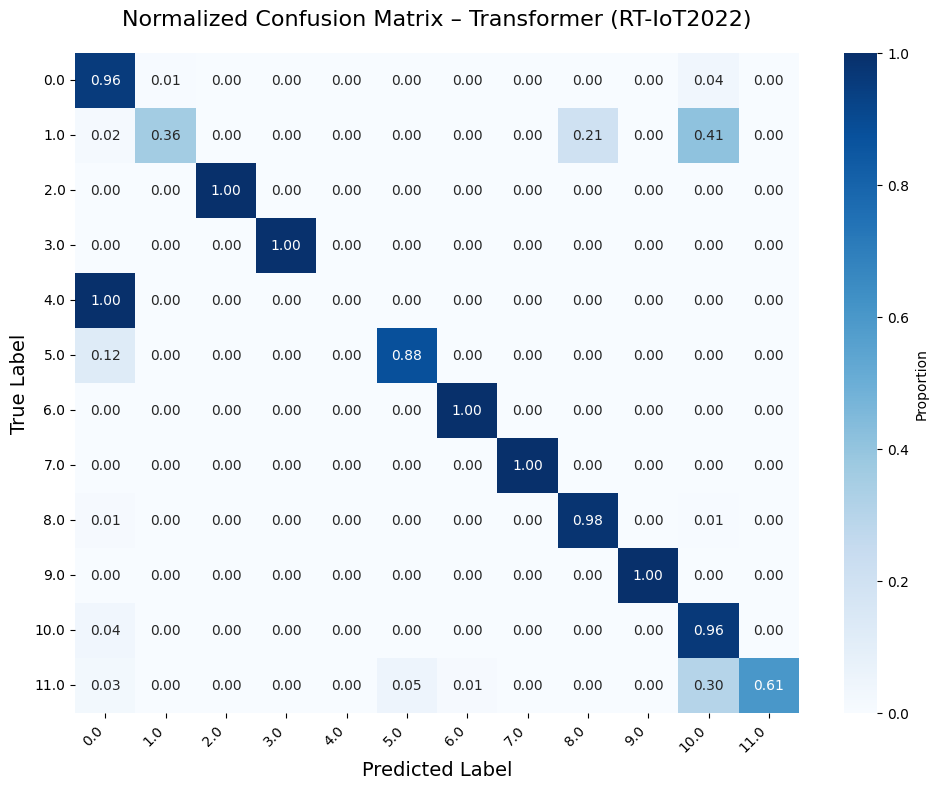

In [91]:
plot_confusion_matrix_pretty(
    transformer,
    X_test,
    y_test,
    class_names
)
